In [1]:
import torch
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
from model.lf_model import LowFidelityPINN
from model.fixed_scheme_model import FixedSchemePINN 
from model.classic_pinn_model import ClassicalPINN 
from utils.pde_utils import evaluate, get_exact_solution, train_universal
from utils.plot_utils import plot_comparison, plot_theta_field

In [2]:
DOMAINS = {
    'heat': {'x': (0.0, 1.0), 't': (0.0, 0.5)},
    'wave': {'x': (0.0, 1.0), 't': (0.0, 1.0)},
    'burgers': {'x': (-1.0, 1.0), 't': (0.01, 0.3)},
    'reaction_diffusion': {'x': (-1.0, 3.0), 't': (0.0, 2.0)}
}

TITLES = {
    'heat': 'Heat Equation',
    'wave': 'Wave Equation',
    'burgers': 'Burgers Equation',
    'reaction_diffusion': 'Reaction-Diffusion'
}

def run_single_test(pde_type, domain, exact_sol, seed, epochs):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    n_steps = 2 if pde_type in ['burgers', 'reaction_diffusion'] else 4
    
    models = [
        ('learnable_theta', 'Low-Fidelity', 
         lambda: LowFidelityPINN(pde_type, n_steps=n_steps, theta_hidden_dim=5)),
        ('explicit', 'Explicit', 
         lambda: FixedSchemePINN(pde_type, scheme='explicit', n_steps=n_steps)),
        ('implicit', 'Implicit', 
         lambda: FixedSchemePINN(pde_type, scheme='implicit', n_steps=n_steps)),
        ('trapezoidal', 'Trapezoidal', 
         lambda: FixedSchemePINN(pde_type, scheme='trapezoidal', n_steps=n_steps)),
        ('classical_pinn', 'Classical', 
         lambda: ClassicalPINN(pde_type, hidden_dim=50))
    ]
    
    results = {}
    
    for method_key, method_name, factory in models:
        print(f"  {method_name}...", end=' ')
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        model = factory()
        history = train_universal(model, domain, epochs=epochs, n_collocation=100)
        res = evaluate(model, domain, exact_solution=exact_sol)
        res['history'] = history
        
        if hasattr(model, 'get_theta_statistics'):
            theta_stats = model.get_theta_statistics(domain)
            res['theta_mean'] = theta_stats['mean']
            res['theta_std'] = theta_stats['std']
        elif hasattr(model, 'fixed_theta'):
            res['theta_mean'] = model.fixed_theta
            res['theta_std'] = 0.0
        
        results[method_key] = res
        print(f"✓ error={res.get('mean_error', 0):.4e}")
    
    return results

def run_multiple_tests(pde_type, n_runs, epochs):
    domain = DOMAINS[pde_type]
    title = TITLES[pde_type]
    exact_sol = get_exact_solution(pde_type)
    
    print(f"\n{'='*80}")
    print(f"ТЕСТИРОВАНИЕ: {title} ({n_runs} runs)")
    print(f"{'='*80}\n")
    
    seeds = [42 + i*111 for i in range(n_runs)]
    all_results = []
    
    for i, seed in enumerate(seeds):
        print(f"\nПрогон {i+1}/{n_runs} (seed={seed}):")
        results = run_single_test(pde_type, domain, exact_sol, seed, epochs)
        all_results.append(results)
    
    analyze_and_plot(all_results, title, domain)
    return all_results

def analyze_and_plot(all_results, title, domain):
    methods = ['learnable_theta', 'explicit', 'implicit', 'trapezoidal', 'classical_pinn']
    names = ['Low-Fidelity', 'Explicit', 'Implicit', 'Trapezoidal', 'Classical']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    stats = {m: {'losses': [], 'errors': [], 'residuals': []} for m in methods}
    
    for results in all_results:
        for method in methods:
            if method in results:
                stats[method]['losses'].append(results[method]['history']['losses'][-1])
                stats[method]['errors'].append(results[method].get('mean_error', 0))
                stats[method]['residuals'].append(results[method]['pde_residual'])
    
    print(f"\n{'='*90}")
    print(f"СТАТИСТИКА: {title}")
    print(f"{'='*90}")
    print(f"{'Метод':<15} {'Loss (μ±σ)':<18} {'Error (μ±σ)':<18} {'Residual (μ±σ)':<18}")
    print("-" * 90)
    
    for method, name in zip(methods, names):
        losses, errors, residuals = stats[method]['losses'], stats[method]['errors'], stats[method]['residuals']
        if losses:
            print(f"{name:<15} {np.mean(losses):.2e}±{np.std(losses):.1e}  "
                  f"{np.mean(errors):.2e}±{np.std(errors):.1e}  "
                  f"{np.mean(residuals):.2e}±{np.std(residuals):.1e}")
    
    # ГРАФИКИ: 2x2
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Средние ошибки
    ax = axes[0, 0]
    means = [np.mean(stats[m]['errors']) for m in methods]
    stds = [np.std(stats[m]['errors']) for m in methods]
    x_pos = np.arange(len(names))
    
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, color=colors, 
                  alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(names, rotation=15, ha='right')
    ax.set_ylabel('Mean Error', fontsize=12)
    ax.set_title(f'{title}: Accuracy', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale('log')
    
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height * 1.5,
                f'{mean:.2e}\n±{std:.1e}', ha='center', va='bottom', fontsize=9)
    
    # 2. Эволюция потерь (пример из первого run)
    ax = axes[0, 1]
    for method, name, color in zip(methods, names, colors):
        if method in all_results[0] and 'history' in all_results[0][method]:
            losses = all_results[0][method]['history']['losses']
            ax.semilogy(losses, label=name, color=color, linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Loss (Example Run)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # 3. Эволюция θ (пример из первого run)
    ax = axes[1, 0]
    if 'learnable_theta' in all_results[0] and 'history' in all_results[0]['learnable_theta']:
        history = all_results[0]['learnable_theta']['history']
        if 'theta_statistics' in history and history['theta_statistics']:
            theta_stats = [s for s in history['theta_statistics'] if s is not None]
            
            if theta_stats:
                theta_means = [s['mean'] for s in theta_stats]
                theta_stds = [s['std'] for s in theta_stats]
                epochs = range(len(theta_means))
                
                ax.plot(epochs, theta_means, 'r-', linewidth=3, label='θ (mean)', alpha=0.8)
                ax.fill_between(epochs, np.array(theta_means) - np.array(theta_stds),
                               np.array(theta_means) + np.array(theta_stds),
                               alpha=0.2, color='red', label='±σ')
                
                ax.axhline(0.0, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Implicit')
                ax.axhline(0.5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Trapezoidal')
                ax.axhline(1.0, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Explicit')
                
                ax.set_xlabel('Epoch', fontsize=12)
                ax.set_ylabel('θ', fontsize=12)
                ax.set_title('θ Evolution (Example Run)', fontsize=14, fontweight='bold')
                ax.legend(fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.set_ylim(-0.1, 1.1)
    
    # 4. θ среднее по всем runs
    ax = axes[1, 1]
    theta_data = []
    for results in all_results:
        if 'learnable_theta' in results:
            theta_mean = results['learnable_theta'].get('theta_mean')
            if theta_mean is not None and isinstance(theta_mean, (int, float)):
                theta_data.append(theta_mean)
    
    if theta_data:
        theta_mean_overall = np.mean(theta_data)
        theta_std_overall = np.std(theta_data)
        
        ax.bar(['Low-Fidelity'], [theta_mean_overall], yerr=[theta_std_overall], 
               capsize=10, color='red', alpha=0.7, edgecolor='black', linewidth=1.5)
        
        ax.axhline(0.0, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Implicit')
        ax.axhline(0.5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Trapezoidal')
        ax.axhline(1.0, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Explicit')
        
        ax.text(0, theta_mean_overall + theta_std_overall * 1.2,
                f'{theta_mean_overall:.3f}±{theta_std_overall:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax.set_ylabel('θ', fontsize=12)
        ax.set_title(f'θ Average Across {len(theta_data)} Runs', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(-0.1, 1.1)
    
    plt.tight_layout()
    plt.show()
    
    plot_solutions(all_results[0], title, domain)

def plot_solutions(results, title, domain):
    methods = ['learnable_theta', 'explicit', 'implicit', 'trapezoidal', 'classical_pinn']
    names = ['Low-Fidelity', 'Explicit', 'Implicit', 'Trapezoidal', 'Classical']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    if 'learnable_theta' not in results or 'u_exact' not in results['learnable_theta']:
        return
    
    points = results['learnable_theta']['points']
    grid_shape = results['learnable_theta']['grid_shape']
    
    x_vals = points[:, 0].detach().cpu().numpy().reshape(grid_shape)
    t_vals = points[:, 1].detach().cpu().numpy().reshape(grid_shape)
    u_exact = results['learnable_theta']['u_exact'].detach().cpu().numpy().reshape(grid_shape)
    
    times = np.linspace(t_vals[0, :].min(), t_vals[0, :].max(), 3)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{title}: Solutions u(x,t)', fontsize=16, fontweight='bold')
    
    for i, t0 in enumerate(times):
        ax = axes[i]
        idx = np.argmin(np.abs(t_vals[0, :] - t0))
        
        ax.plot(x_vals[:, idx], u_exact[:, idx], 'k-', linewidth=3, label='Exact', alpha=0.8)
        
        for method, name, color in zip(methods, names, colors):
            if method in results and 'u_pred' in results[method]:
                u_pred = results[method]['u_pred'].detach().cpu().numpy().reshape(grid_shape)
                ax.plot(x_vals[:, idx], u_pred[:, idx], '--', color=color, linewidth=2, label=name, alpha=0.7)
        
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('u(x,t)', fontsize=12)
        ax.set_title(f't = {t0:.3f}', fontsize=13)
        if i == 0:
            ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_all_pde_tests(epochs=500):
    configs = [('heat', 5), ('wave', 5), ('burgers', 5), ('reaction_diffusion', 5)]
    all_pde_results = {}
    
    for pde, n_runs in configs:
        print(f"\n\n{'#'*80}")
        print(f"# {pde.upper()}")
        print(f"{'#'*80}\n")
        results = run_multiple_tests(pde, n_runs=n_runs, epochs=epochs)
        all_pde_results[pde] = results
    
    plot_final_comparison(all_pde_results)
    return all_pde_results

def plot_final_comparison(all_pde_results):
    methods = ['learnable_theta', 'explicit', 'implicit', 'trapezoidal', 'classical_pinn']
    names = ['Low-Fidelity', 'Explicit', 'Implicit', 'Trapezoidal', 'Classical']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    pde_names = ['Heat', 'Wave', 'Burgers', 'Reaction-Diff']
    
    fig, ax = plt.subplots(figsize=(14, 8))
    x_pos = np.arange(len(pde_names))
    bar_width = 0.15
    
    for i, (method, name, color) in enumerate(zip(methods, names, colors)):
        means, stds = [], []
        for pde_type, results_list in all_pde_results.items():
            errors = [r[method].get('mean_error', 0) for r in results_list if method in r]
            means.append(np.mean(errors) if errors else 0)
            stds.append(np.std(errors) if errors else 0)
        
        ax.bar(x_pos + i*bar_width, means, bar_width, yerr=stds, label=name, 
               color=color, alpha=0.7, capsize=3, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('PDE Type', fontsize=14, fontweight='bold')
    ax.set_ylabel('Mean Error (μ±σ)', fontsize=14, fontweight='bold')
    ax.set_title('All Methods on All PDEs', fontsize=16, fontweight='bold')
    ax.set_xticks(x_pos + bar_width*2)
    ax.set_xticklabels(pde_names, fontsize=12)
    ax.legend(fontsize=11, loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()



################################################################################
# HEAT
################################################################################


ТЕСТИРОВАНИЕ: Heat Equation (5 runs)


Прогон 1/5 (seed=42):
  Low-Fidelity... 
Low-Fidelity PINN
PDE: heat | Steps: 4 | Params: 26

   Epoch    0: Loss=1.14e-01, PDE=1.14e-01, BC=1.01e-15, IC=0.00e+00, θ=0.499±0.000
   Epoch  100: Loss=1.45e-02, PDE=1.45e-02, BC=8.54e-16, IC=0.00e+00, θ=0.429±0.009
   Epoch  200: Loss=5.04e-03, PDE=5.04e-03, BC=8.89e-16, IC=0.00e+00, θ=0.392±0.012
   Epoch  300: Loss=3.99e-03, PDE=3.99e-03, BC=1.15e-15, IC=0.00e+00, θ=0.378±0.013
   Epoch  400: Loss=3.75e-03, PDE=3.75e-03, BC=9.80e-16, IC=0.00e+00, θ=0.377±0.013
   Epoch  500: Loss=3.99e-03, PDE=3.99e-03, BC=3.11e-16, IC=0.00e+00, θ=0.373±0.012
   Epoch  600: Loss=2.82e-03, PDE=2.82e-03, BC=8.01e-16, IC=0.00e+00, θ=0.371±0.014
   Epoch  700: Loss=3.26e-03, PDE=3.26e-03, BC=1.01e-15, IC=0.00e+00, θ=0.372±0.015
   Epoch  800: Loss=3.

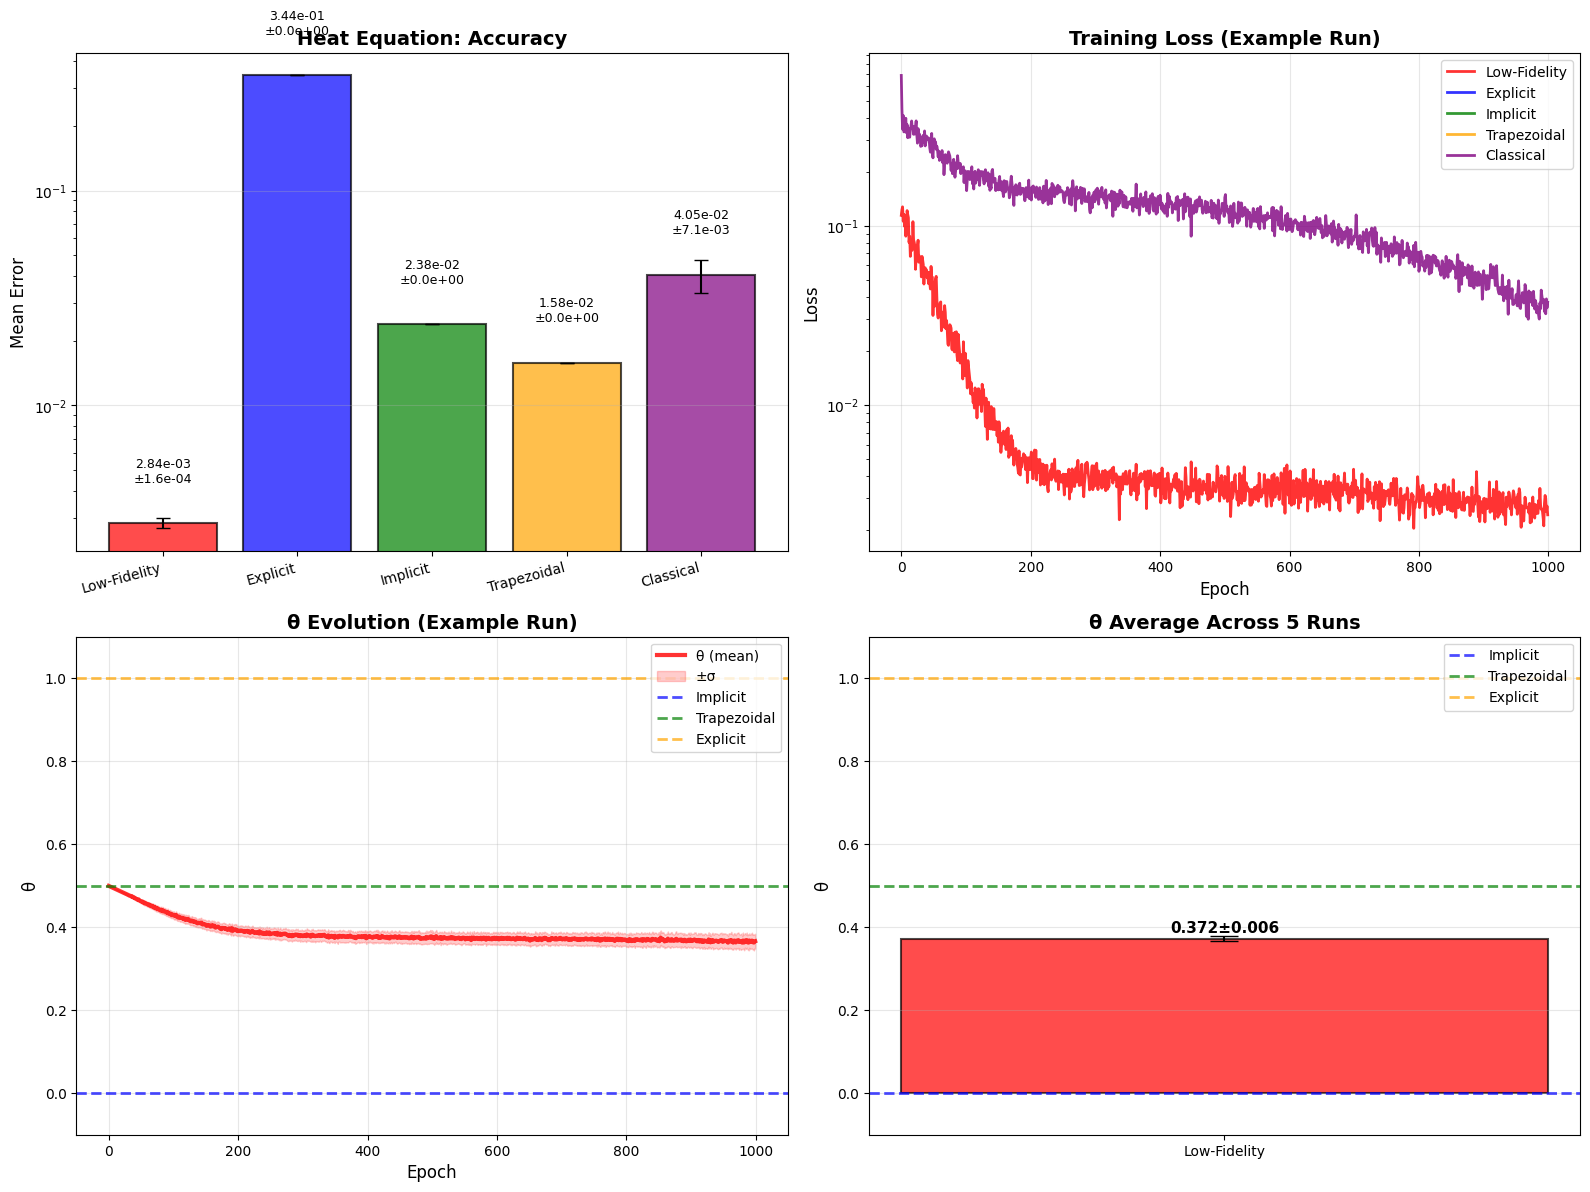

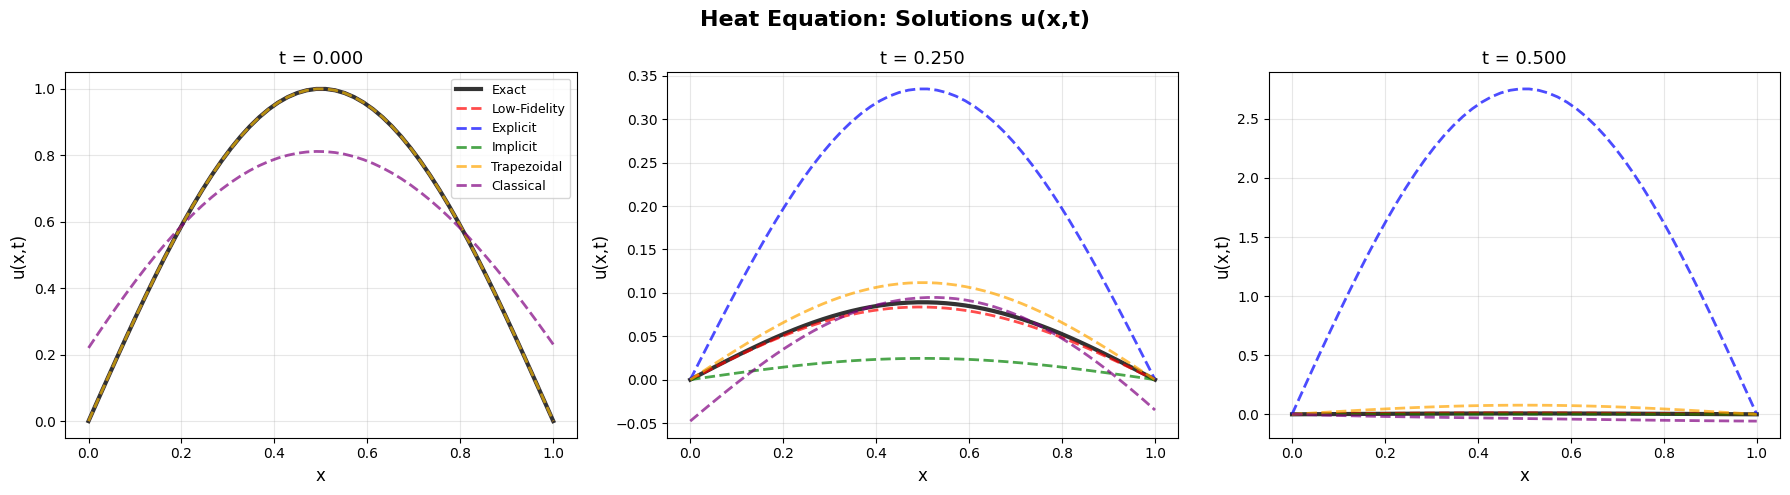



################################################################################
# WAVE
################################################################################


ТЕСТИРОВАНИЕ: Wave Equation (5 runs)


Прогон 1/5 (seed=42):
  Low-Fidelity... 
Low-Fidelity PINN
PDE: wave | Steps: 4 | Params: 26

   Epoch    0: Loss=7.79e-01, PDE=7.79e-01, BC=4.40e-15, IC=0.00e+00, θ=0.499±0.000
   Epoch  100: Loss=7.28e-01, PDE=7.28e-01, BC=5.18e-15, IC=0.00e+00, θ=0.475±0.009
   Epoch  200: Loss=6.85e-01, PDE=6.85e-01, BC=5.39e-15, IC=0.00e+00, θ=0.468±0.023
   Epoch  300: Loss=5.99e-01, PDE=5.99e-01, BC=5.03e-15, IC=0.00e+00, θ=0.440±0.039
   Epoch  400: Loss=5.27e-01, PDE=5.27e-01, BC=4.71e-15, IC=0.00e+00, θ=0.439±0.061
   Epoch  500: Loss=3.70e-01, PDE=3.70e-01, BC=4.56e-15, IC=0.00e+00, θ=0.422±0.083
   Epoch  600: Loss=3.48e-01, PDE=3.48e-01, BC=4.42e-15, IC=0.00e+00, θ=0.402±0.106
   Epoch  700: Loss=2.60e-01, PDE=2.60e-01, BC=4.27e-15, IC=0.00e+00, θ=0.416±0.120
   Epoch  800: Loss=2.

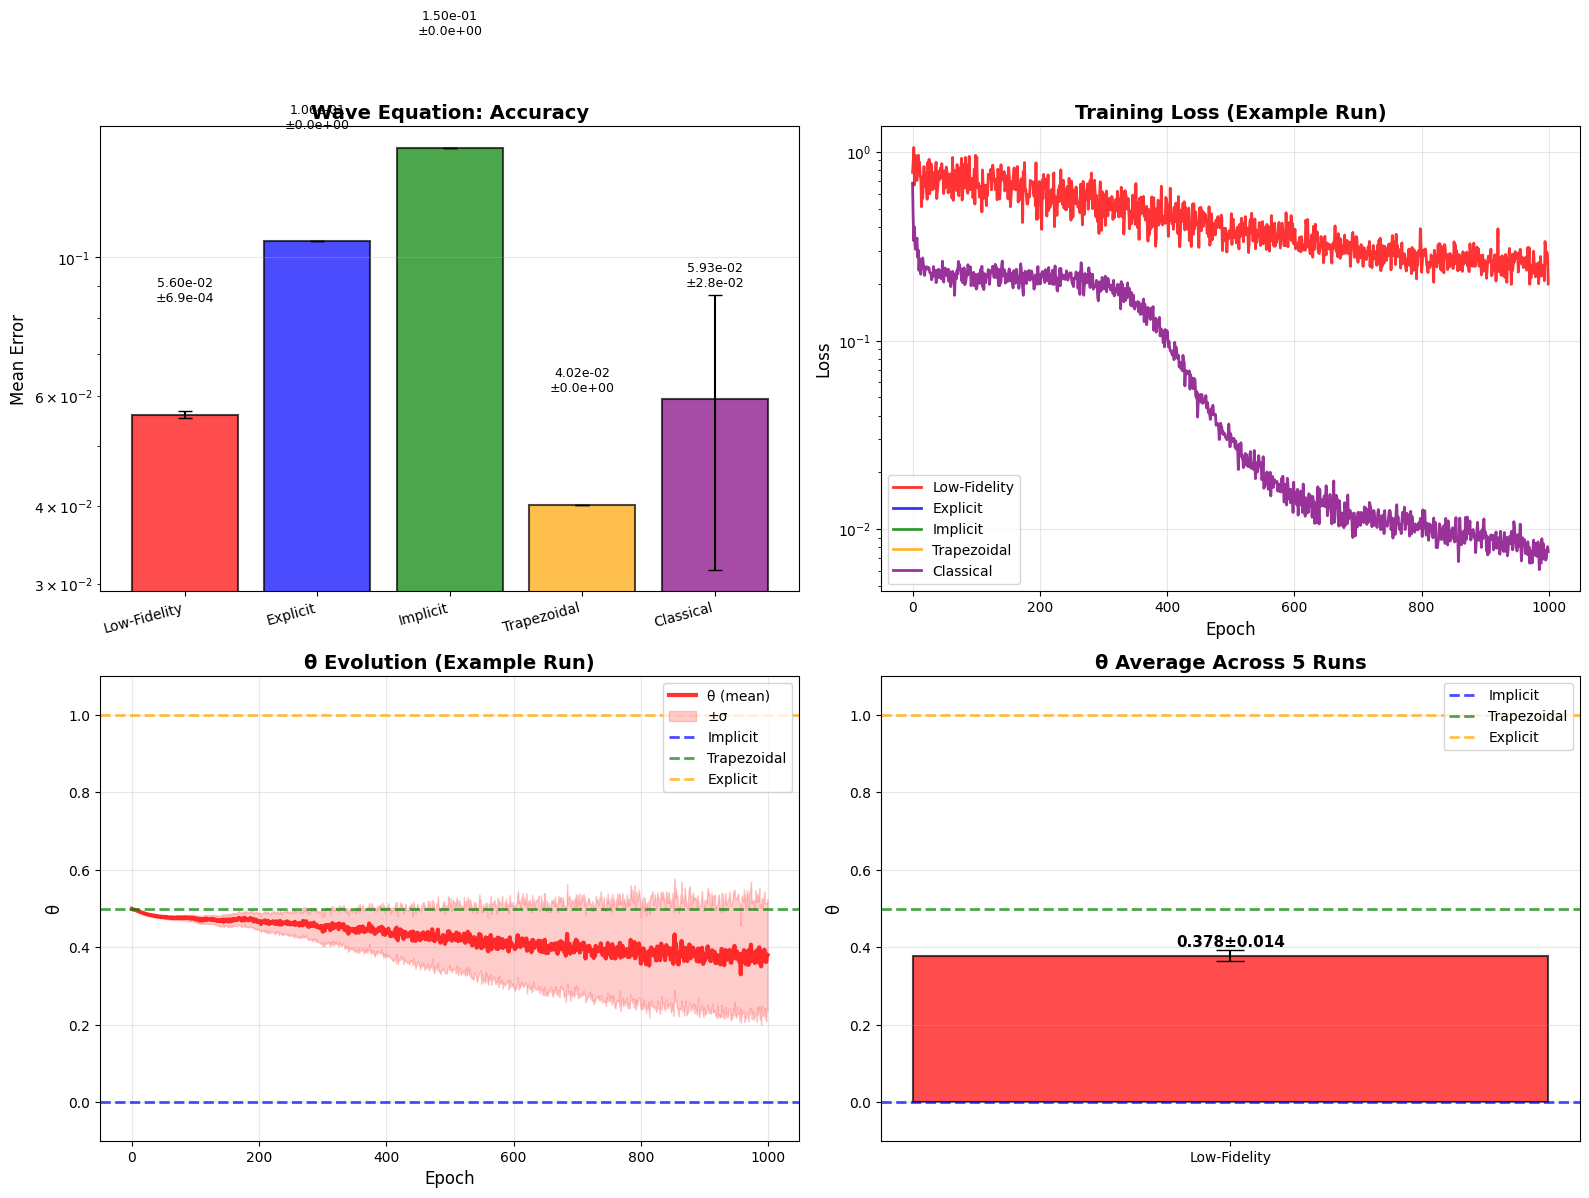

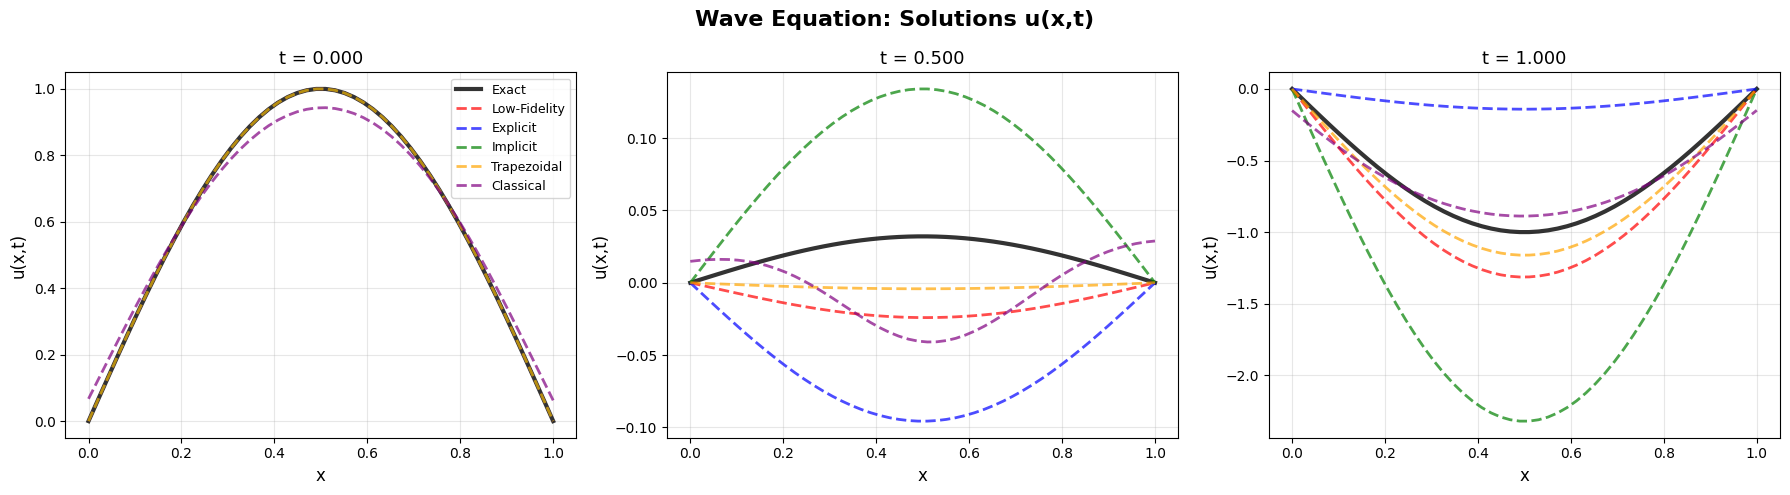



################################################################################
# BURGERS
################################################################################


ТЕСТИРОВАНИЕ: Burgers Equation (5 runs)


Прогон 1/5 (seed=42):
  Low-Fidelity... 
Low-Fidelity PINN
PDE: burgers | Steps: 2 | Params: 26

   Epoch    0: Loss=2.50e-01, PDE=2.50e-01, BC=1.64e-14, IC=0.00e+00, θ=0.499±0.000
   Epoch  100: Loss=2.20e-01, PDE=2.20e-01, BC=1.53e-14, IC=0.00e+00, θ=0.446±0.005
   Epoch  200: Loss=8.08e-02, PDE=8.08e-02, BC=1.49e-14, IC=0.00e+00, θ=0.386±0.006
   Epoch  300: Loss=1.84e-01, PDE=1.84e-01, BC=1.61e-14, IC=0.00e+00, θ=0.353±0.006
   Epoch  400: Loss=8.23e-02, PDE=8.23e-02, BC=1.53e-14, IC=0.00e+00, θ=0.343±0.007
   Epoch  500: Loss=4.31e-02, PDE=4.31e-02, BC=1.29e-14, IC=0.00e+00, θ=0.340±0.006
   Epoch  600: Loss=1.42e-01, PDE=1.42e-01, BC=1.54e-14, IC=0.00e+00, θ=0.332±0.008
   Epoch  700: Loss=7.08e-02, PDE=7.08e-02, BC=1.66e-14, IC=0.00e+00, θ=0.331±0.009
   Epoch  800

/Users/igor.velikorechanin/Desktop/Masters/Thesis/Trapezioid Architecture PINN/utils/pde_utils.py:205: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  num, _ = quad(num_int, -10, 10, limit=100)
/Users/igor.velikorechanin/Desktop/Masters/Thesis/Trapezioid Architecture PINN/utils/pde_utils.py:205: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  num, _ = quad(num_int, -10, 10, limit=100)
/Users/igor.velikorechanin/Desktop/Masters/Thesis/Trapezioid Architecture PINN/utils/pde_utils.py:206: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  den, _ = quad(den_int, -10, 10, limit=100)


✓ error=2.0999e-02
  Explicit... 
Fixed Scheme PINN
PDE: burgers | Scheme: explicit | θ: 1.0 | Steps: 2

✓ error=4.7840e-02
  Implicit... 
Fixed Scheme PINN
PDE: burgers | Scheme: implicit | θ: 0.0 | Steps: 2

✓ error=4.4528e-02
  Trapezoidal... 
Fixed Scheme PINN
PDE: burgers | Scheme: trapezoidal | θ: 0.5 | Steps: 2

✓ error=1.9190e-02
  Classical...    Epoch    0: Loss=5.23e-01, PDE=1.70e-03, BC=5.41e-02, IC=4.67e-01, Classical
   Epoch  100: Loss=4.20e-01, PDE=3.37e-03, BC=2.07e-02, IC=3.96e-01, Classical
   Epoch  200: Loss=2.17e-01, PDE=6.80e-02, BC=7.34e-03, IC=1.42e-01, Classical
   Epoch  300: Loss=1.50e-01, PDE=2.82e-02, BC=8.99e-03, IC=1.13e-01, Classical
   Epoch  400: Loss=1.22e-01, PDE=3.49e-02, BC=7.80e-03, IC=7.94e-02, Classical
   Epoch  500: Loss=9.51e-02, PDE=3.47e-02, BC=9.52e-03, IC=5.08e-02, Classical
   Epoch  600: Loss=8.09e-02, PDE=2.53e-02, BC=6.55e-03, IC=4.91e-02, Classical
   Epoch  700: Loss=8.13e-02, PDE=2.57e-02, BC=8.99e-03, IC=4.67e-02, Classical
   Ep

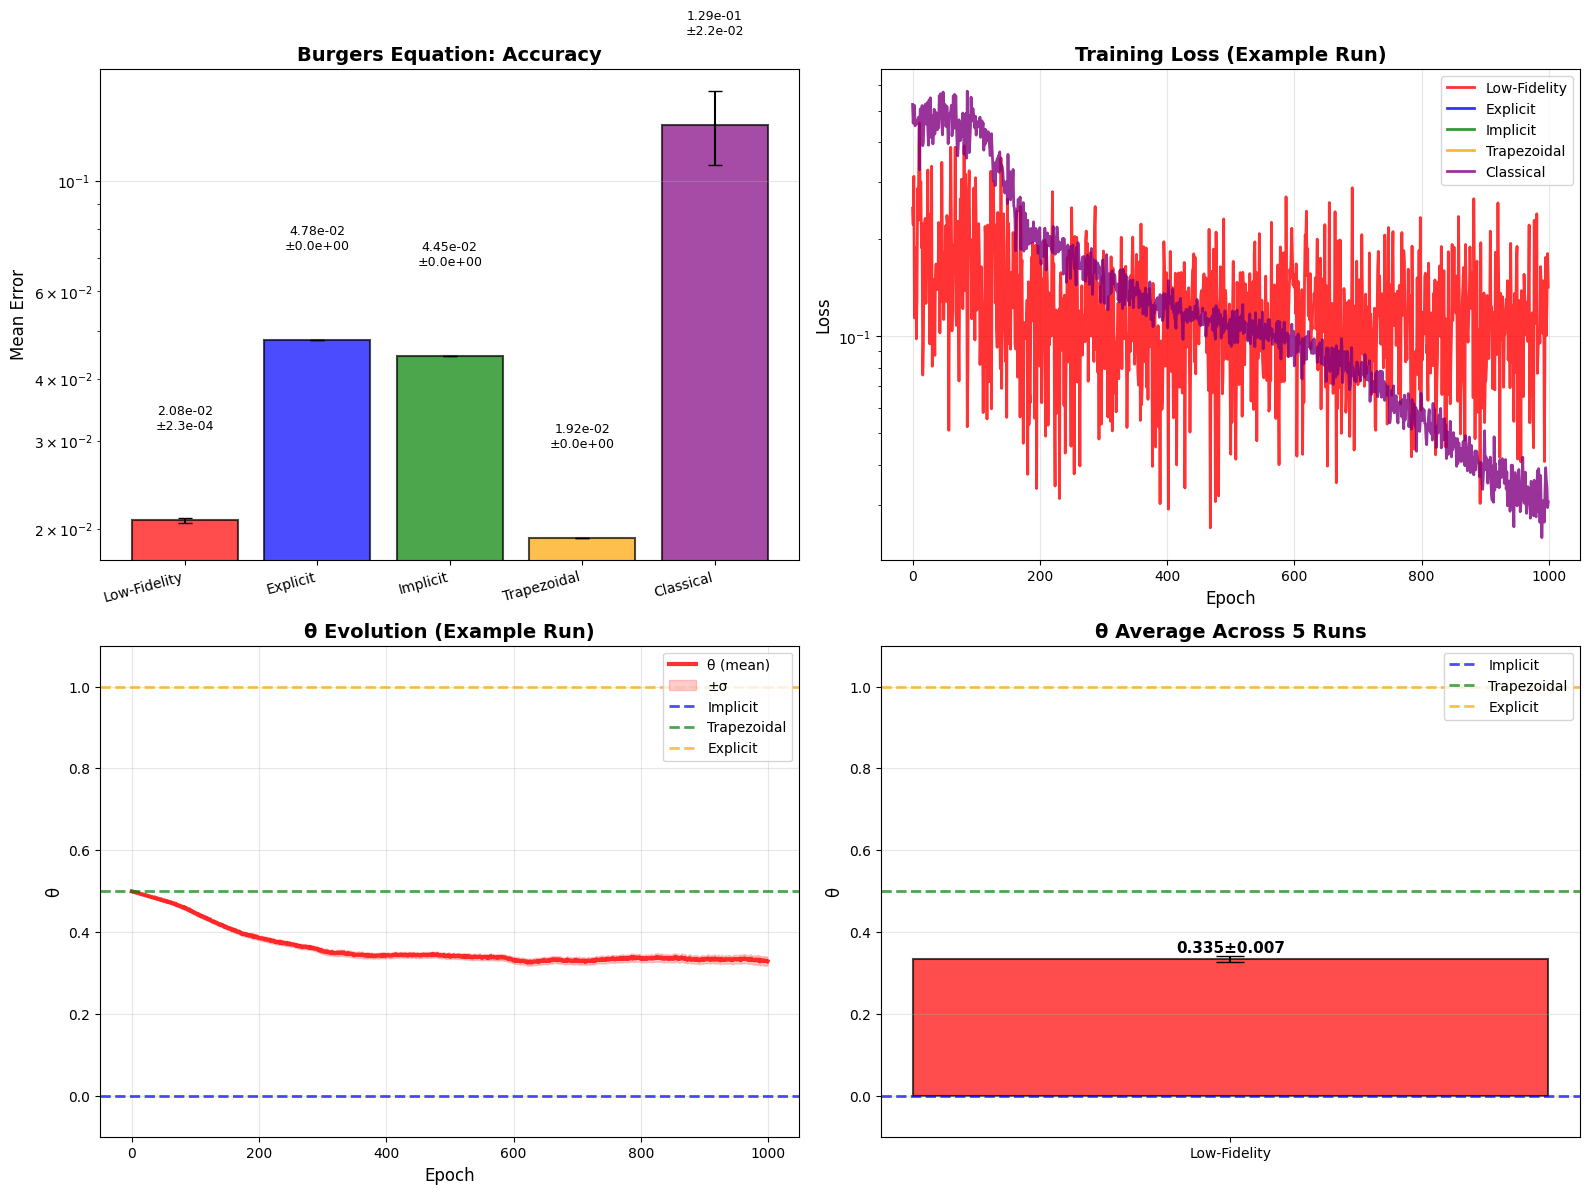

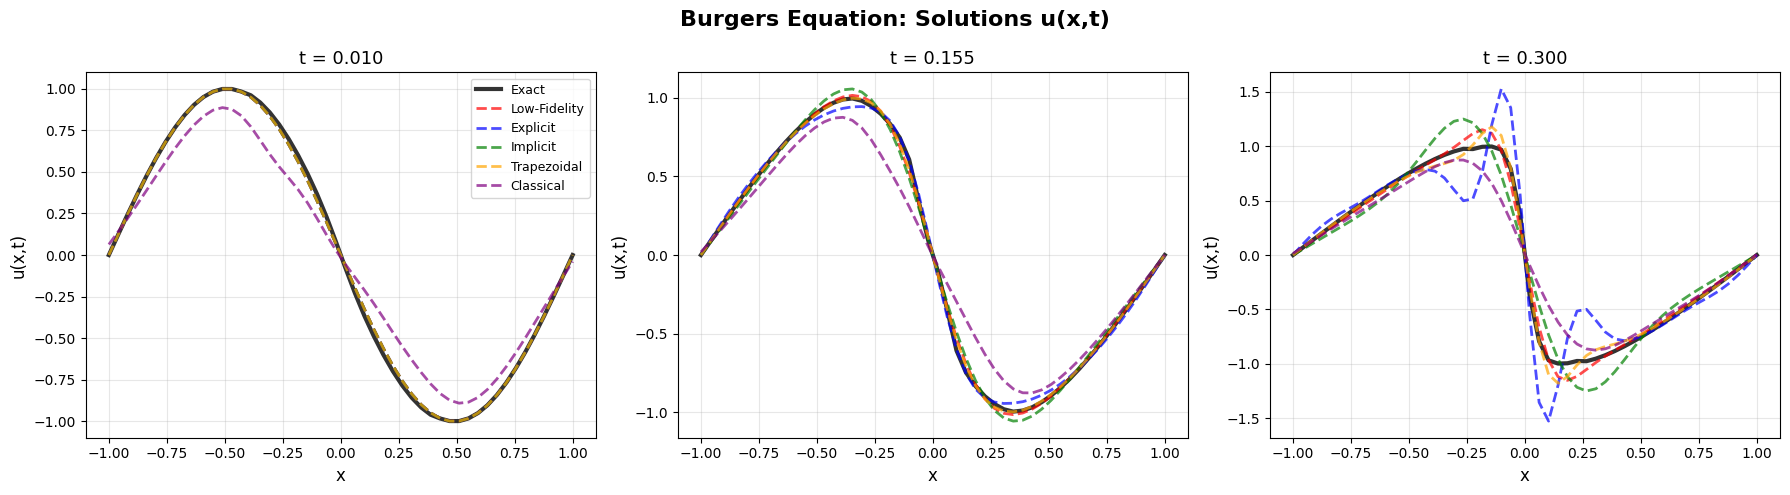



################################################################################
# REACTION_DIFFUSION
################################################################################


ТЕСТИРОВАНИЕ: Reaction-Diffusion (5 runs)


Прогон 1/5 (seed=42):
  Low-Fidelity... 
Low-Fidelity PINN
PDE: reaction_diffusion | Steps: 2 | Params: 26

   Epoch    0: Loss=7.55e+00, PDE=7.55e+00, BC=3.70e-10, IC=0.00e+00, θ=0.499±0.000
   Epoch  100: Loss=3.35e+00, PDE=3.35e+00, BC=2.81e-10, IC=0.00e+00, θ=0.410±0.024
   Epoch  200: Loss=1.79e+00, PDE=1.79e+00, BC=1.86e-10, IC=0.00e+00, θ=0.282±0.043
   Epoch  300: Loss=1.44e+00, PDE=1.44e+00, BC=7.87e-11, IC=0.00e+00, θ=0.167±0.036
   Epoch  400: Loss=3.68e-02, PDE=3.68e-02, BC=6.65e-11, IC=0.00e+00, θ=0.122±0.041
   Epoch  500: Loss=5.73e-03, PDE=5.73e-03, BC=7.74e-11, IC=0.00e+00, θ=0.098±0.026
   Epoch  600: Loss=2.39e-04, PDE=2.39e-04, BC=5.07e-11, IC=0.00e+00, θ=0.096±0.038
   Epoch  700: Loss=1.06e-02, PDE=1.06e-02, BC=3.96e-11, IC=0.00e+00, θ=0

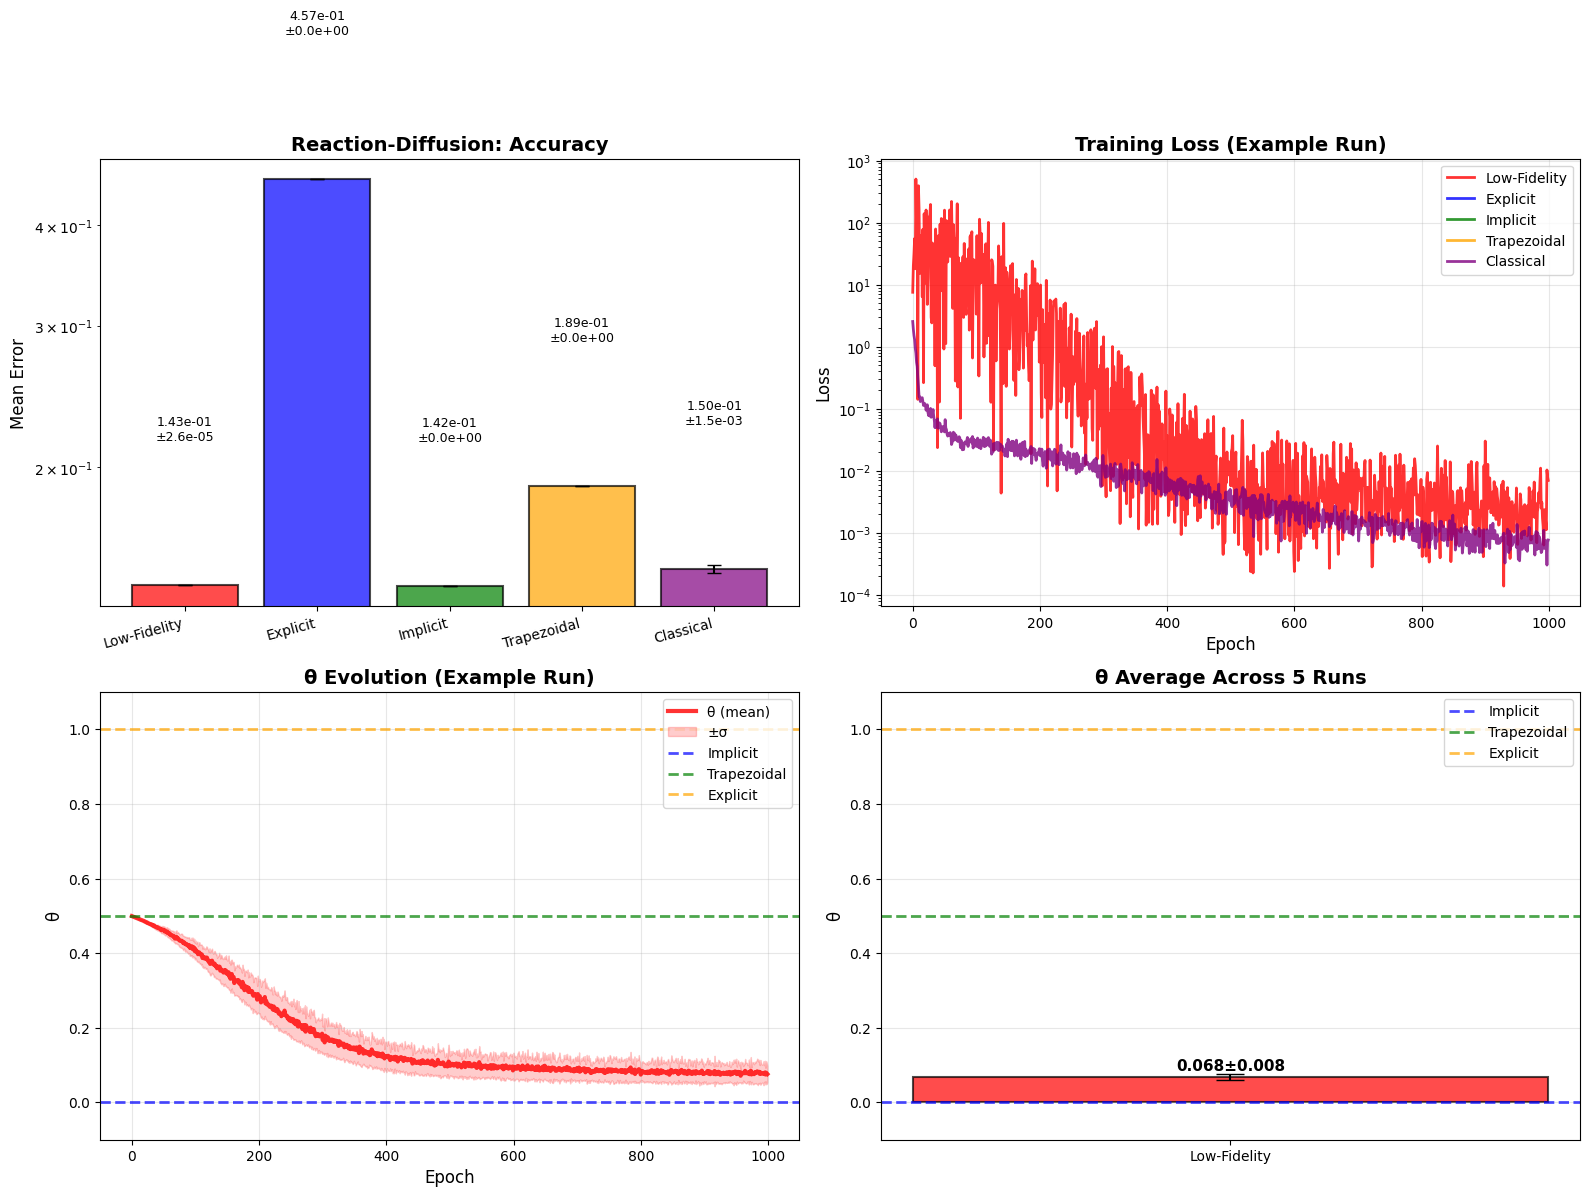

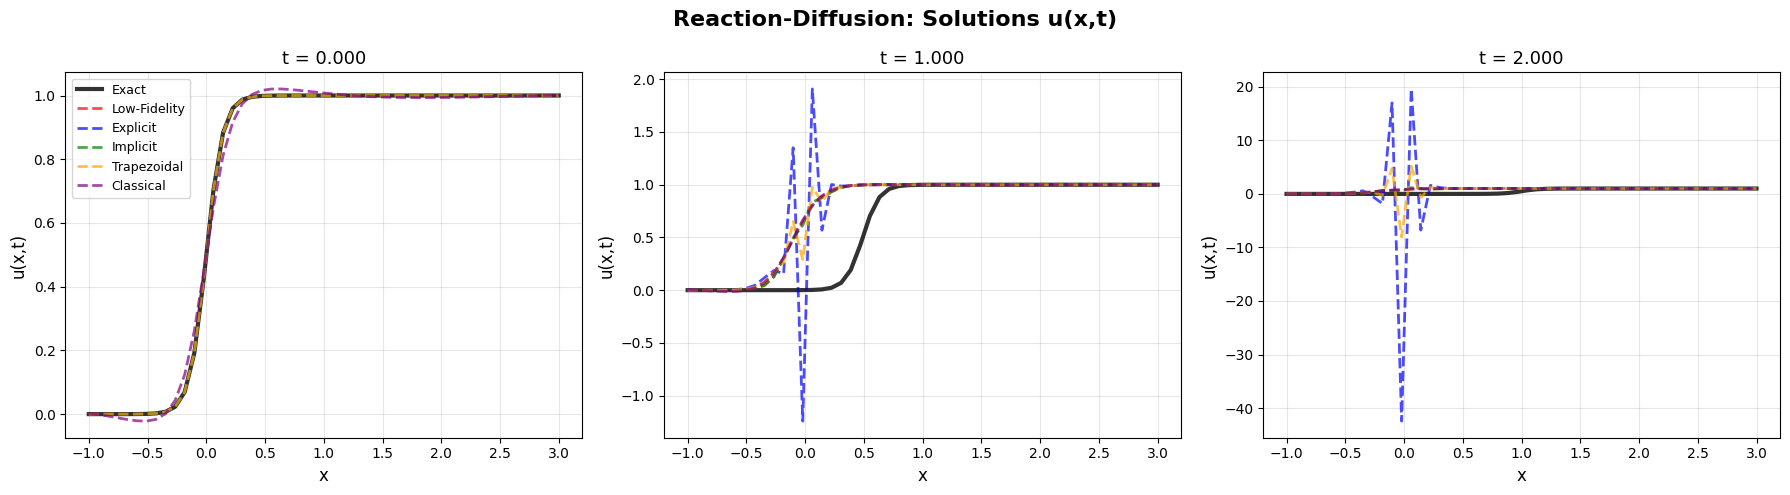

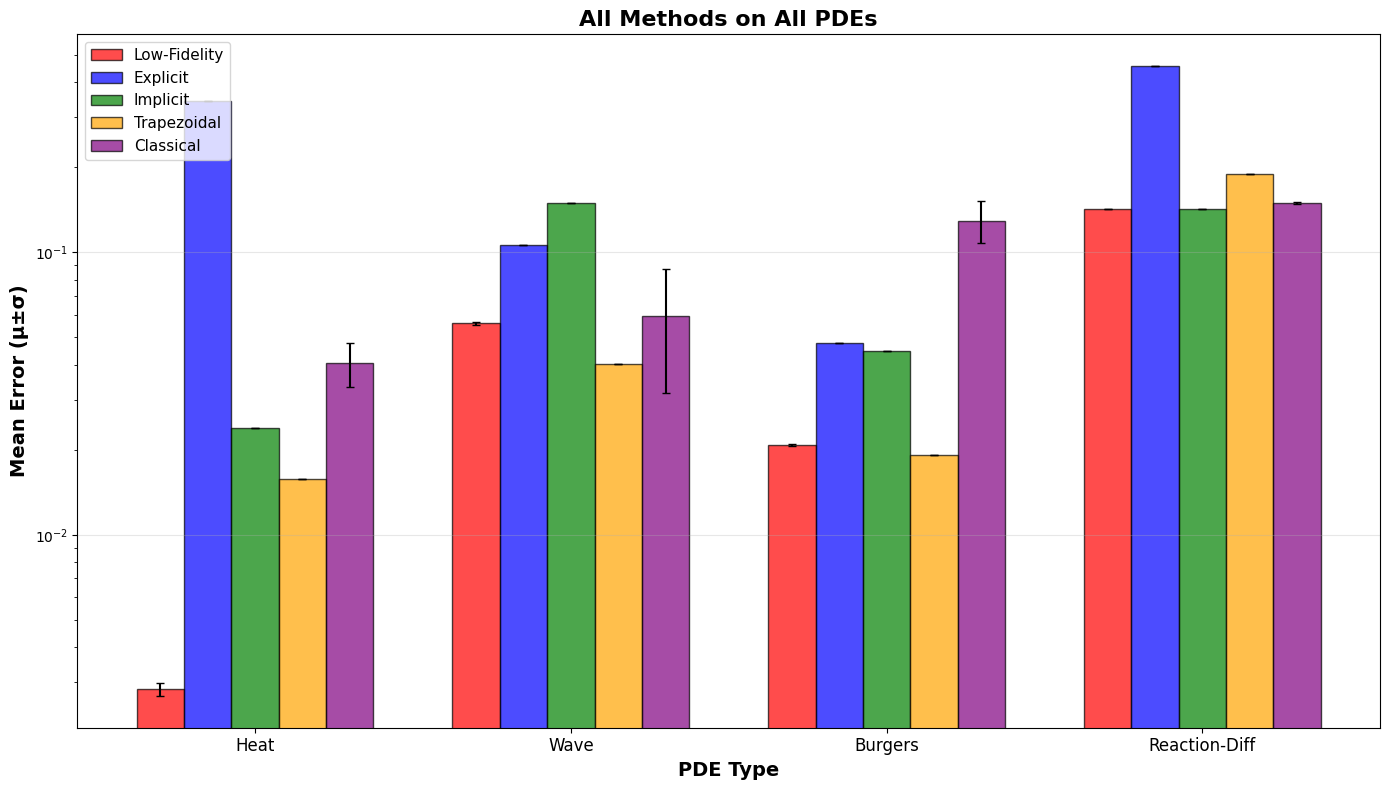

In [3]:
all_results = run_all_pde_tests(epochs=1000)
